<a href="https://colab.research.google.com/github/xiaochengJF/MachineLearning/blob/master/Ex2__Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/MachineLearning/ex2-logistic regression

/content/drive/My Drive/MachineLearning/ex2-logistic regression


# 2. logistic_regression（逻辑回归）

# 备注
运行环境：python 3.6  
现在我知道我应该考虑列向量，而Tensorflow对数据的形状非常挑剔。 但是在numpy中，正常的一维ndarray已经被表示为列向量。 如果我重新塑造$\mathbb{R}^n$ 为 $\mathbb{R}^{n\times1}$，它不再是列向量了，而是是1列的矩阵,那使用scipy会有麻烦。
*所以我们应该把TensorFlow的数据视为特殊情况。 我们继续使用numpy的惯例。

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import matplotlib.pyplot as plt
# import tensorflow as tf
from sklearn.metrics import classification_report  # 这个包是评价报告

# 准备数据

In [4]:
data = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'admitted'])
data.head()  # 看前五行

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [5]:
data.describe()

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000



TypeError: unhashable type: '_ColorPalette'  
解决方法： color_codes=False

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


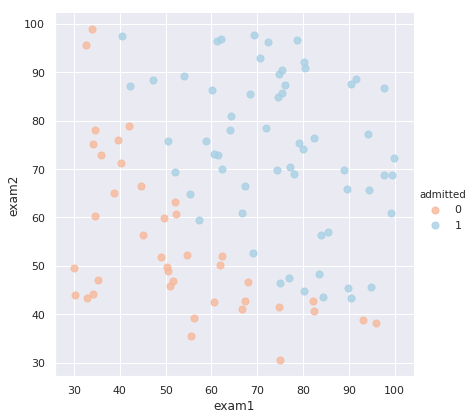

In [6]:
sns.set(context="notebook", style="darkgrid", palette=sns.color_palette("RdBu", 2), color_codes=False)
sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )
plt.show()  # 看下数据的样子

In [0]:
def get_X(df):#读取特征
#     """
#     use concat to add intersect feature to avoid side effect
#     not efficient for big dataset though
#     """
    ones = pd.DataFrame({'ones': np.ones(len(df))})  # ones是m行1列的dataframe
    data = pd.concat([ones, df], axis=1)  # 合并数据，根据列合并
    return data.iloc[:, :-1].as_matrix()  # 这个操作返回 ndarray,不是矩阵


def get_y(df):#读取标签
#     '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])  # df.iloc[:, -1]是指df的最后一列


def normalize_feature(df):
#     """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())  # 特征缩放

In [8]:
X = get_X(data)
print(X.shape)

y = get_y(data)
print(y.shape)

(100, 3)
(100,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为： \\[g\left( z \right)=\frac{1}{1+{{e}^{-z}}}\\] 
合起来，我们得到逻辑回归模型的假设函数： 
	\\[{{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}\\] 


In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

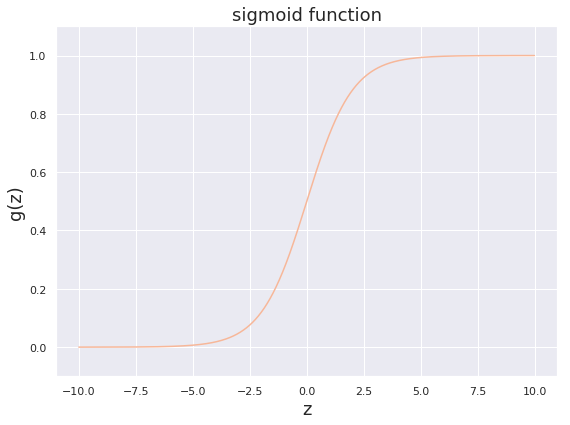

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(np.arange(-10, 10, step=0.01),
        sigmoid(np.arange(-10, 10, step=0.01)))
ax.set_ylim((-0.1,1.1))
ax.set_xlabel('z', fontsize=18)
ax.set_ylabel('g(z)', fontsize=18)
ax.set_title('sigmoid function', fontsize=18)
plt.show()

# cost function(代价函数)
> * $\max(\ell(\theta)) = min(-\ell(\theta))$  
> * 选择 $-\ell(\theta)$ 作为 $\color{pink}{cost\ function}$

$$\begin{align}
  J\left( \theta  \right) &=-\frac{1}{m}\sum\limits_{i=1}^{m}{\left[{{y}^{(i)}}\log ( {{h}_{\theta }}( {{x}^{(i)}}))+( 1-{{y}^{(i)}} )\log ( 1-{{h}_{\theta }}( {{x}^{(i)}} ))\right]} \\ 
 & =\frac{1}{m}\sum\limits_{i=1}^{m}{\left[-{{y}^{(i)}}\log ( {{h}_{\theta }}( {{x}^{(i)}} ) )-( 1-{{y}^{(i)}} )\log ( 1-{{h}_{\theta }}( {{x}^{(i)}}))\right]} \\ 
\end{align}$$


In [11]:
theta = np.zeros(3) # X(m*n) so theta is n*1
print("theta:",theta)
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))  # X @ theta与X.dot(theta)等价

print("cost:",cost(theta, X, y))

theta: [0. 0. 0.]
cost: 0.6931471805599453


# gradient descent(梯度下降)
* 这是批量梯度下降（$\text{batch gradient descent}$）  
* 转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$  

$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [0]:
def gradient(theta, X, y):
#     '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

In [13]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

# 拟合参数  
<font face=楷体 color=green size=4>绿色链接：</font>  

【1】[`scipy.optimize.minimize`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)   
【2】[最优化学习笔记](https://www.cnblogs.com/NaughtyBaby/p/5590081.html)


In [14]:
import scipy.optimize as opt
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method='Newton-CG', jac=gradient)  # 寻找参数
print(res)

     fun: 0.203497708881501
     jac: array([-8.26207510e-06, -3.70033535e-04, -3.97954680e-04])
 message: 'Optimization terminated successfully.'
    nfev: 72
    nhev: 0
     nit: 29
    njev: 254
  status: 0
 success: True
       x: array([-25.16833701,   0.20628773,   0.20152827])


# 用训练集预测和验证

In [0]:
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

In [16]:
final_theta = res.x  
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86        40
           1       0.90      0.92      0.91        60

    accuracy                           0.89       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.89      0.89       100



# 寻找决策边界

 $X \times \theta = 0$  

<font face=楷体 color=green size=4>**绿色链接:**</font>  
【1】[Why is logistic regression a linear classifier](http://stats.stackexchange.com/questions/93569/why-is-logistic-regression-a-linear-classifier)

In [17]:
print(res.x)  # this is final theta

[-25.16833701   0.20628773   0.20152827]


In [18]:
coef = -(res.x / res.x[2])  # find the equation
print(coef)

x = np.arange(130, step=0.1)
y = coef[0] + coef[1]*x  # 最优线

[124.88737673  -1.02361684  -1.        ]


In [19]:
data.describe()  # find the range of x and y

,exam1,exam2,admitted
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


<font face=楷体 color=skyblue size=4>$x$和$y$的截距都在125左右</font>

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


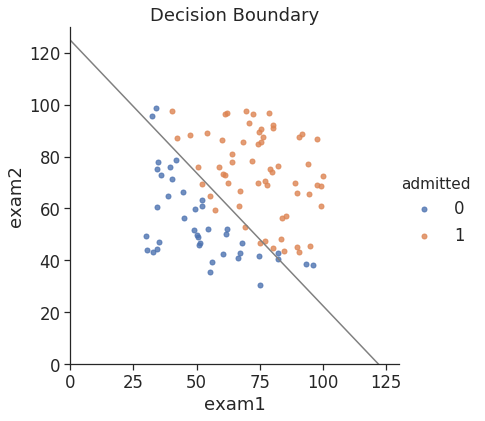

In [20]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('exam1', 'exam2', hue='admitted', data=data, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 25}
          )

plt.plot(x, y, 'grey')
plt.xlim(0, 130)
plt.ylim(0, 130)
plt.title('Decision Boundary')
plt.show()

# 3- 正则化逻辑回归

In [21]:
df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
df.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


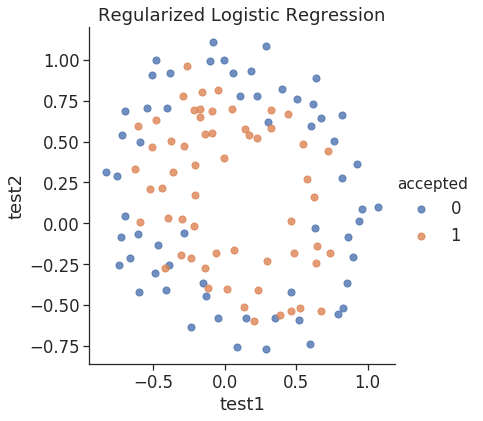

In [22]:
sns.set(context="notebook", style="ticks", font_scale=1.5)

sns.lmplot('test1', 'test2', hue='accepted', data=df, 
           size=6, 
           fit_reg=False, 
           scatter_kws={"s": 50}
          )

plt.title('Regularized Logistic Regression')
plt.show()

# feature mapping（特征映射）

<font face=楷体 color=skyblue size=4>多项式展开</font>

```
for i in 0..i
  for p in 0..i:
    output x^(i-p) * y^p
```

$$mapFeature(x)=
\left[\begin{array}{c}{1\\x_1\\x_2\\x_1^2\\x_1x_2\\x^2_2\\x_1^3\\\ \ \vdots\\x_1x_2^5\\x_2^6}\end{array}\right]
$$
<font face=楷体 color=yellow size=4>**疑问：**</font>  
二项式???????????????????????????????????????????????????????????????????  

<font face=楷体 color=green size=4>**绿色链接：**</font>  
【1】[Python format 格式化函数](https://www.runoob.com/python/att-string-format.html)

In [0]:
def feature_mapping(x, y, power, as_ndarray=False):
#     """return mapped features as ndarray or dataframe"""
    # data = {}
    # # inclusive
    # for i in np.arange(power + 1):
    #     for p in np.arange(i + 1):
    #         data["f{}{}".format(i - p, p)] = np.power(x, i - p) * np.power(y, p)

    data = {"f{}{}".format(i - p, p): np.power(x, i - p) * np.power(y, p)
                for i in np.arange(power + 1)
                for p in np.arange(i + 1)
            }

    if as_ndarray:
        return pd.DataFrame(data).as_matrix()
    else:
        return pd.DataFrame(data)

In [0]:
x1 = np.array(df.test1)
x2 = np.array(df.test2)

In [25]:
data = feature_mapping(x1, x2, power=6)
print(data.shape)
data.head()

(118, 28)


,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,f40,f31,f22,f13,f04,f50,f41,f32,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,0.000007,0.000094,0.001286,0.017551,0.239497,3.541519e-07,0.000005,0.000066,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,0.000074,-0.000546,0.004035,-0.029801,0.220095,-6.860919e-06,0.000051,-0.000374,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,0.002086,-0.006757,0.021886,-0.070895,0.229642,-4.457837e-04,0.001444,-0.004677,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,0.019775,-0.026483,0.035465,-0.047494,0.063602,-7.415771e-03,0.009931,-0.013299,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,0.069393,-0.062956,0.057116,-0.051818,0.047011,-3.561597e-02,0.032312,-0.029315,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


In [26]:
data.describe()

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,f40,f31,f22,f13,f04,f50,f41,f32,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
count,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,118.000000,1.180000e+02,118.000000,118.000000,118.000000,1.180000e+02,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02,118.000000,1.180000e+02
mean,1.0,0.054779,0.183102,0.247575,-0.025472,0.301370,5.983333e-02,0.030682,0.015483,0.142350,1.225384e-01,-0.005251,0.050433,-0.011048,1.710985e-01,5.196507e-02,0.011812,9.432094e-03,0.018278,4.089084e-03,0.115710,7.837118e-02,-0.000703,1.893340e-02,-0.001705,2.259170e-02,-0.006302,1.257256e-01
std,0.0,0.496654,0.519743,0.248532,0.224075,0.284536,2.746459e-01,0.134706,0.150143,0.326134,2.092709e-01,0.096738,0.068211,0.116735,2.815658e-01,2.148098e-01,0.072274,5.455787e-02,0.058513,9.993907e-02,0.299092,1.938621e-01,0.058271,3.430092e-02,0.037443,4.346935e-02,0.090621,2.964416e-01
min,1.0,-0.830070,-0.769740,0.000040,-0.484096,0.000026,-5.719317e-01,-0.358121,-0.483743,-0.456071,1.612020e-09,-0.296854,0.000006,-0.483390,6.855856e-10,-3.940702e-01,-0.246068,-1.592528e-01,-0.142660,-4.830370e-01,-0.270222,6.472253e-14,-0.203971,2.577297e-10,-0.113448,2.418097e-10,-0.482684,1.795116e-14
25%,1.0,-0.372120,-0.254385,0.043243,-0.178209,0.061086,-5.155632e-02,-0.023672,-0.042980,-0.016492,1.869975e-03,-0.029360,0.004076,-0.046392,3.741593e-03,-7.147973e-03,-0.001926,-3.659760e-03,-0.001400,-7.449462e-03,-0.001072,8.086369e-05,-0.006381,1.258285e-04,-0.005749,3.528590e-04,-0.016662,2.298277e-04
50%,1.0,-0.006336,0.213455,0.165397,-0.016521,0.252195,-2.544062e-07,0.006603,-0.000039,0.009734,2.736163e-02,-0.000512,0.018229,-0.000446,6.360222e-02,-1.021440e-11,0.000205,-1.473547e-07,0.001026,-8.972096e-09,0.000444,4.527344e-03,-0.000004,3.387050e-03,-0.000005,3.921378e-03,-0.000020,1.604015e-02
75%,1.0,0.478970,0.646562,0.389925,0.100795,0.464189,1.099616e-01,0.086392,0.079510,0.270310,1.520801e-01,0.015050,0.070063,0.012576,2.155453e-01,2.526861e-02,0.019183,1.370560e-02,0.021148,2.751341e-02,0.113020,5.932959e-02,0.002104,2.090875e-02,0.001024,2.103622e-02,0.001289,1.001215e-01
max,1.0,1.070900,1.108900,1.146827,0.568307,1.229659,1.228137e+00,0.449251,0.505577,1.363569,1.315212e+00,0.369805,0.322973,0.449772,1.512062e+00,1.408460e+00,0.304409,2.451845e-01,0.287323,4.012965e-01,1.676725,1.508320e+00,0.250577,2.018260e-01,0.183548,2.556084e-01,0.436209,1.859321e+00


# regularized cost（正则化代价函数）
$$J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [27]:
theta = np.zeros(data.shape[1])
print(theta.shape)
X = feature_mapping(x1, x2, power=6, as_ndarray=True)
print(X.shape)

y = get_y(df)
print(y.shape)

(28,)
(118, 28)
(118,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


In [0]:
#正则化代价函数
def regularized_cost(theta, X, y, l=1):
    '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term

In [29]:
regularized_cost(theta, X, y, l=1)

0.6931471805599454

<font face=楷体 color=skyblue>因为设置theta为0，所以正则化代价函数与代价函数的值相同

# regularized gradient(正则化梯度)
$$\frac{\partial J\left( \theta  \right)}{\partial {{\theta }_{j}}}=\left( \frac{1}{m}\sum\limits_{i=1}^{m}{\left( {{h}_{\theta }}\left( {{x}^{\left( i \right)}} \right)-{{y}^{\left( i \right)}} \right)} \right)+\frac{\lambda }{m}{{\theta }_{j}}\text{ }，\ \quad for  \ j\ge \text{1}$$

In [0]:
def regularized_gradient(theta, X, y, l=1):
    '''
    still, leave theta_0 alone
    '''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

In [31]:
regularized_gradient(theta, X, y)

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

# 拟合参数

In [0]:
import scipy.optimize as opt

In [33]:
print('init cost = {}'.format(regularized_cost(theta, X, y)))

res = opt.minimize(fun=regularized_cost, x0=theta, args=(X, y), method='Newton-CG', jac=regularized_gradient)
res

init cost = 0.6931471805599454


     fun: 0.5290027297127532
     jac: array([ 2.49665979e-08,  6.75202012e-11,  1.08466174e-07,  3.35532344e-08,
        1.89306448e-08, -8.27493330e-09,  1.66090341e-08,  2.61579069e-08,
        1.30397526e-08,  1.77535925e-08, -1.67712492e-08, -4.54007164e-10,
       -2.85071983e-08,  5.92452807e-09, -3.30678421e-08,  8.84446122e-09,
        1.64202223e-08, -8.36491532e-09, -1.84171537e-09,  1.07600649e-08,
       -1.89008161e-08, -7.18406743e-09,  1.59962038e-09, -1.25117485e-08,
       -5.03956881e-09, -1.21487383e-08,  2.04940517e-09, -4.00864843e-08])
 message: 'Optimization terminated successfully.'
    nfev: 7
    nhev: 0
     nit: 6
    njev: 68
  status: 0
 success: True
       x: array([ 1.27273858,  0.62527136,  1.18108796, -2.01996006, -0.91742423,
       -1.43166336,  0.12400688, -0.3655345 , -0.35723914, -0.1751299 ,
       -1.45815771, -0.05098963, -0.61555643, -0.27470696, -1.19281589,
       -0.24218798, -0.2060058 , -0.04473123, -0.27778487, -0.29537783,
       -0.4

# 预测

In [34]:
final_theta = res.x
y_pred = predict(X, final_theta)

print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.75      0.82        60
           1       0.78      0.91      0.84        58

    accuracy                           0.83       118
   macro avg       0.84      0.83      0.83       118
weighted avg       0.84      0.83      0.83       118



# 使用不同的 $\lambda$ （这个是常数）
<font face=楷体 color=skyblue size=4>画出决策边界</font>
<font face=楷体>
* 找到所有满足 $X\times \theta = 0$ 的$X$
* 不用解多项式方程，只需要创建一个密度足够大的网格，然后找出所有的$X\times\theta\approx 0$，然后画出来
</font>

In [0]:
def draw_boundary(power, l):
    """
    power: polynomial power for mapped feature
    l: lambda constant
    """
    density = 1000
    threshhold = 2 * 10**-3

    final_theta = feature_mapped_logistic_regression(power, l)
    x, y = find_decision_boundary(density, power, final_theta, threshhold)

    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    sns.lmplot('test1', 'test2', hue='accepted', data=df, size=6, fit_reg=False, scatter_kws={"s": 100})

    plt.scatter(x, y, c='R', s=10)
    plt.title('Decision boundary')
    plt.show()

In [0]:
def feature_mapped_logistic_regression(power, l):
    """for drawing purpose only.. not a well generealize logistic regression
    power: int
        raise x1, x2 to polynomial power
    l: int
        lambda constant for regularization term
    """
    df = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
    x1 = np.array(df.test1)
    x2 = np.array(df.test2)
    y = get_y(df)

    X = feature_mapping(x1, x2, power, as_ndarray=True)
    theta = np.zeros(X.shape[1])

    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient)
    final_theta = res.x

    return final_theta

<font face=楷体 color=yellow size=4>**疑问：**</font>  
decision = mapped_cord[np.abs(inner_product) < threshhold]  
<font face=楷体 color=green size=4>绿色链接：</font>  
【1】[Python zip()](https://www.programiz.com/python-programming/methods/built-in/zip)

In [0]:
#寻找决策边界函数
def find_decision_boundary(density, power, theta, threshhold):
    t1 = np.linspace(-1, 1.5, density)
    t2 = np.linspace(-1, 1.5, density)

    cordinates = [(x, y) for x in t1 for y in t2]
    x_cord, y_cord = zip(*cordinates)  # * 表示解压返回tuple
    mapped_cord = feature_mapping(x_cord, y_cord, power)  # this is a dataframe

    inner_product = mapped_cord.as_matrix() @ theta

    decision = mapped_cord[np.abs(inner_product) < threshhold]

    return decision.f10, decision.f01

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


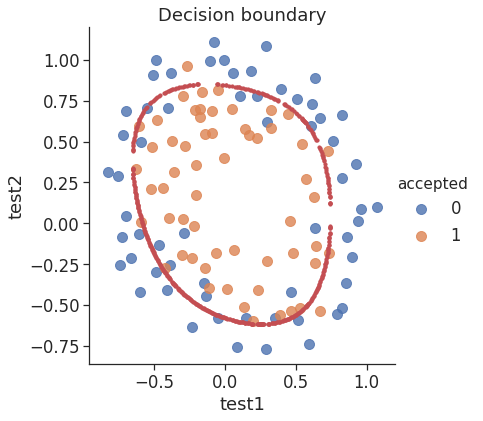

In [38]:
draw_boundary(power=6, l=1)  # lambda=1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


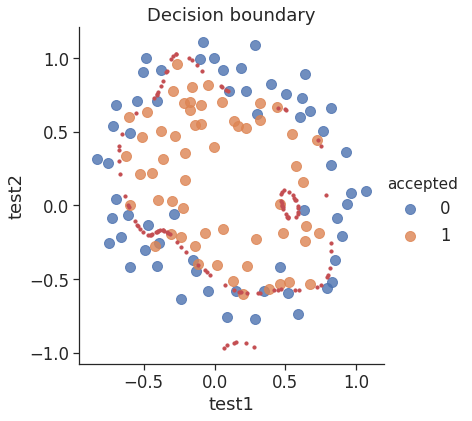

In [39]:
draw_boundary(power=6, l=0)  # lambda=0,没有正则化，过拟合了

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


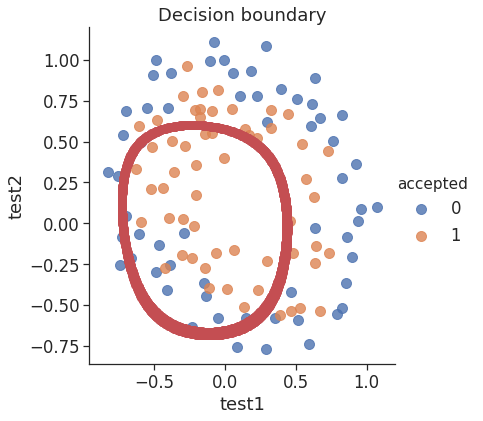

In [40]:
draw_boundary(power=6, l=100)  # lambda=100,欠拟合